<a href="https://colab.research.google.com/github/tonmoyShivam/FinalYear/blob/main/Lung_Cancer_Setection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import needed modules

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


### Data Preprocessing

In [2]:
# Generate data paths with labels
data_dir = '/content/drive/MyDrive/Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

filepaths  \
0      /content/drive/MyDrive/Dataset/colon_image_set...   
1      /content/drive/MyDrive/Dataset/colon_image_set...   
2      /content/drive/MyDrive/Dataset/colon_image_set...   
3      /content/drive/MyDrive/Dataset/colon_image_set...   
4      /content/drive/MyDrive/Dataset/colon_image_set...   
...                                                  ...   
22133  /content/drive/MyDrive/Dataset/lung_image_sets...   
22134  /content/drive/MyDrive/Dataset/lung_image_sets...   
22135  /content/drive/MyDrive/Dataset/lung_image_sets...   
22136  /content/drive/MyDrive/Dataset/lung_image_sets...   
22137  /content/drive/MyDrive/Dataset/lung_image_sets...   

                             labels  
0              Colon Adenocarcinoma  
1              Colon Adenocarcinoma  
2              Colon Adenocarcinoma  
3              Colon Adenocarcinoma  
4              Colon Adenocarcinoma  
...                             ...  
22133  Lung Squamous Cell Carcinoma  
22134  Lung Squamous Cell Carcinoma  
22135  Lung Squamous Cell Carcinoma  
22136  Lung Squamous Cell Carcinoma  
22137  Lung Squamous Cell Carcinoma  

[22138 rows x 2 columns]

### Split data into train, valid, and test

In [4]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

### Create image data generator

In [5]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 17710 validated image filenames belonging to 5 classes.
Found 2214 validated image filenames belonging to 5 classes.
Found 2214 validated image filenames belonging to 5 classes.


### Show sample from train data

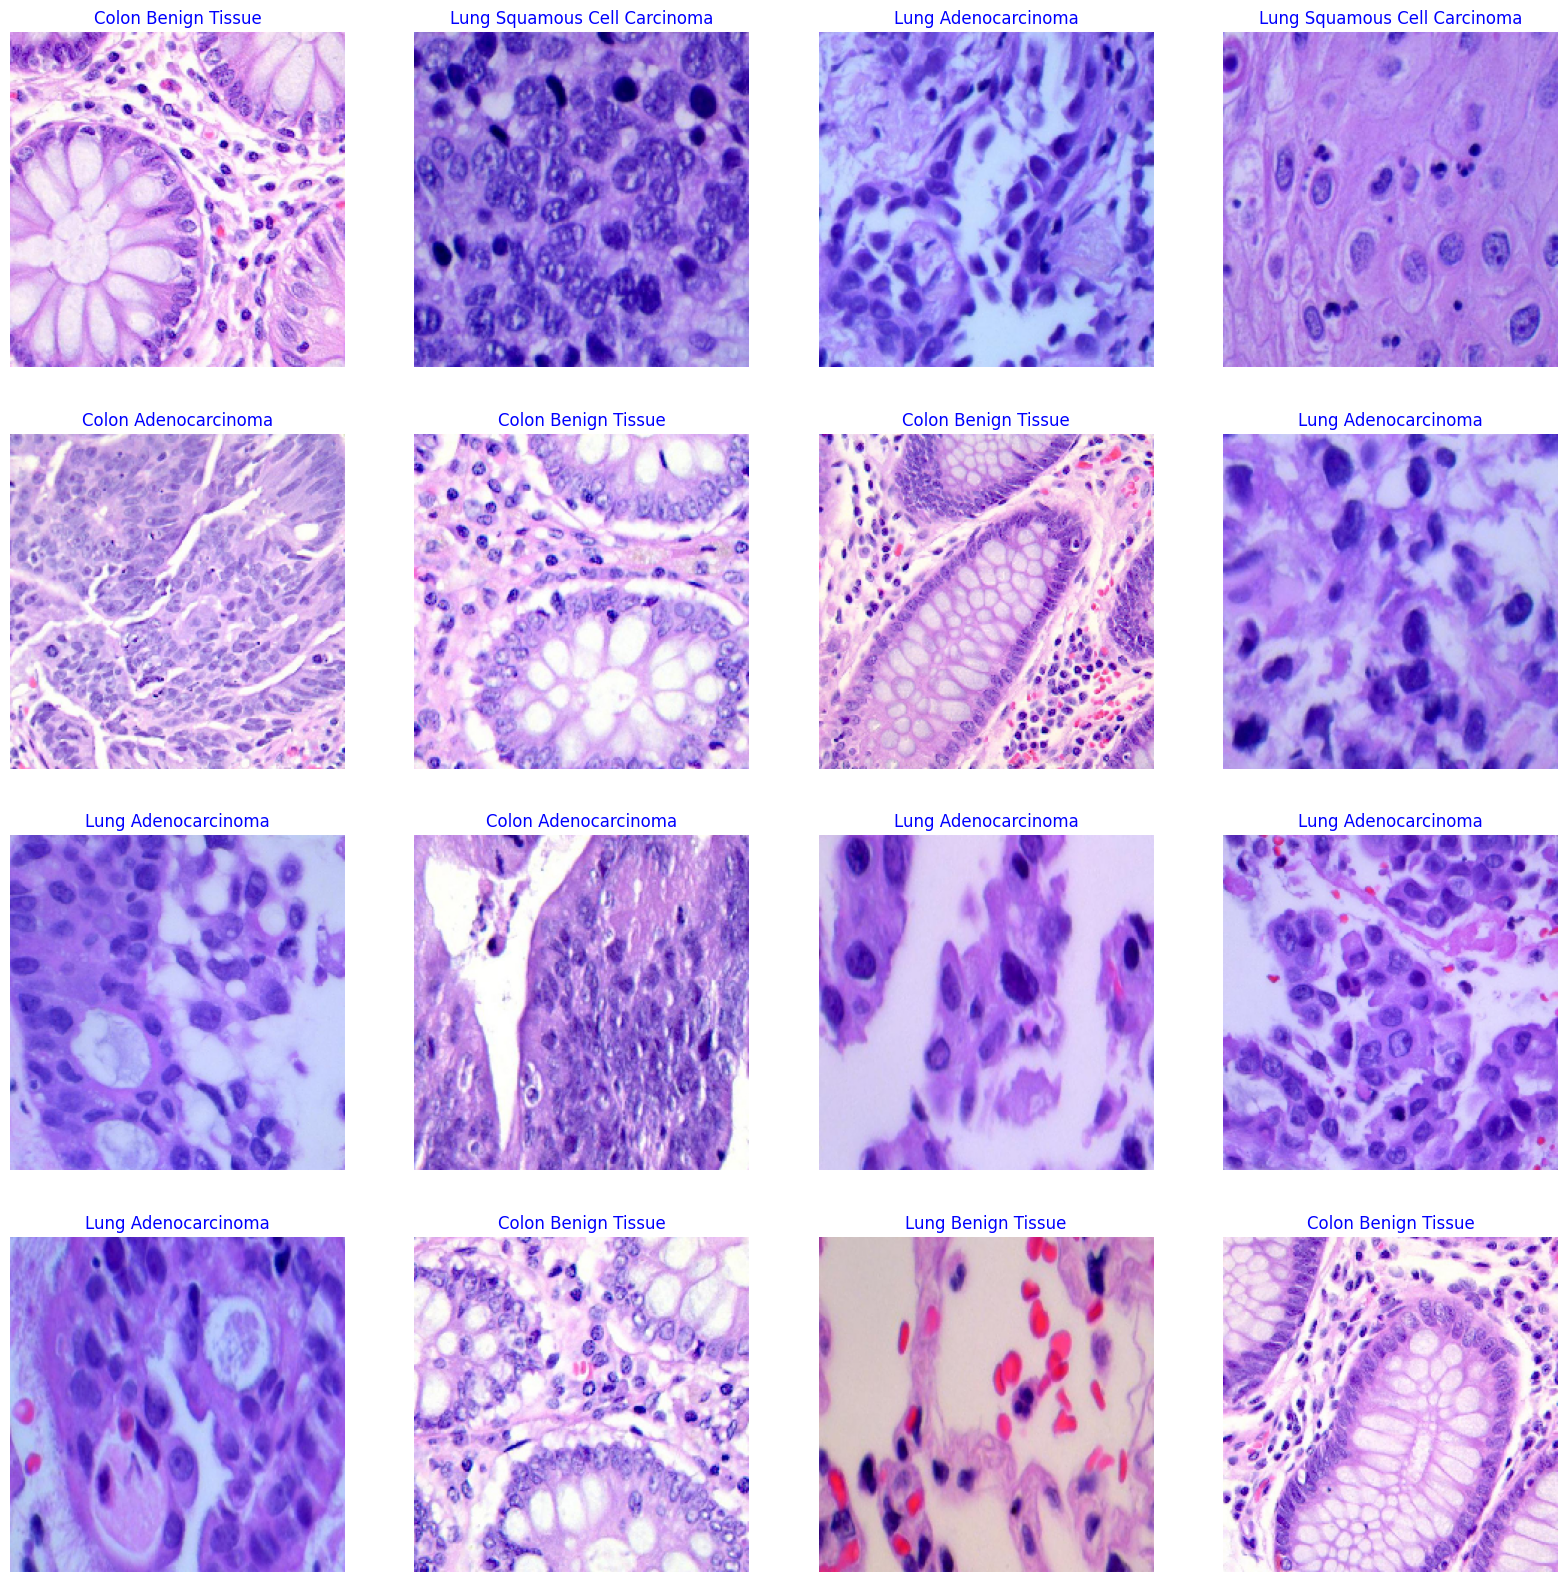

In [6]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

### Model Structure

## Generic Model Creation

In [7]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

### Train model

In [8]:
epochs = 20   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/20
277/277 [==============================] - 6532s 24s/step - loss: 3.6636 - accuracy: 0.6087 - val_loss: 0.4670 - val_accuracy: 0.7918
Epoch 2/20
277/277 [==============================] - 172s 621ms/step - loss: 0.3045 - accuracy: 0.8845 - val_loss: 0.2390 - val_accuracy: 0.9137
Epoch 3/20
277/277 [==============================] - 170s 613ms/step - loss: 0.1931 - accuracy: 0.9300 - val_loss: 0.2071 - val_accuracy: 0.9322
Epoch 4/20
277/277 [==============================] - 173s 626ms/step - loss: 0.1600 - accuracy: 0.9420 - val_loss: 0.1914 - val_accuracy: 0.9322
Epoch 5/20
277/277 [==============================] - 172s 619ms/step - loss: 0.1214 - accuracy: 0.9561 - val_loss: 0.1261 - val_accuracy: 0.9517
Epoch 6/20
277/277 [==============================] - 167s 603ms/step - loss: 0.0931 - accuracy: 0.9662 - val_loss: 0.1349 - val_accuracy: 0.9566
Epoch 7/20
277/277 [==============================] - 170s 612ms/step - loss: 0.0876 - accuracy: 0.9651 - val_loss: 0.1764 - 

## Display model performance

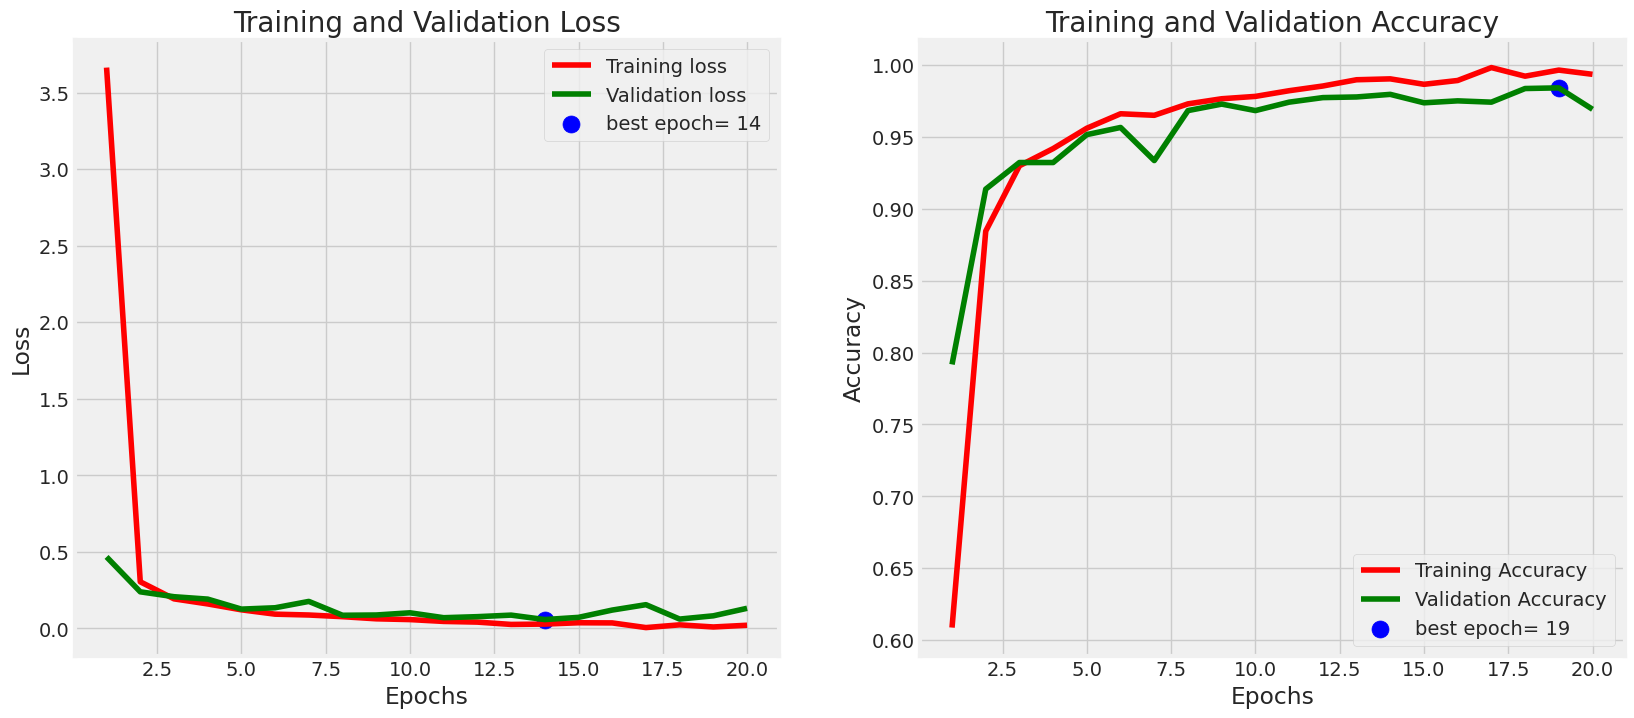

In [9]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### Evaluate model

In [10]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

35/41 [========================>.....] - ETA: 2:02 - loss: 0.0895 - accuracy: 0.9724

35/41 [========================>.....] - ETA: 3s - loss: 0.1314 - accuracy: 0.9693

41/41 [==============================] - 18s 430ms/step - loss: 0.1314 - accuracy: 0.9693
Train Loss:  0.028355374932289124
Train Accuracy:  0.9904725551605225
--------------------
Valid Loss:  0.08949065208435059
Valid Accuracy:  0.9724480509757996
--------------------
Test Loss:  0.1314338594675064
Test Accuracy:  0.9692863821983337


### Get Predictions

In [11]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

## Confusion Matrics and Classification Report

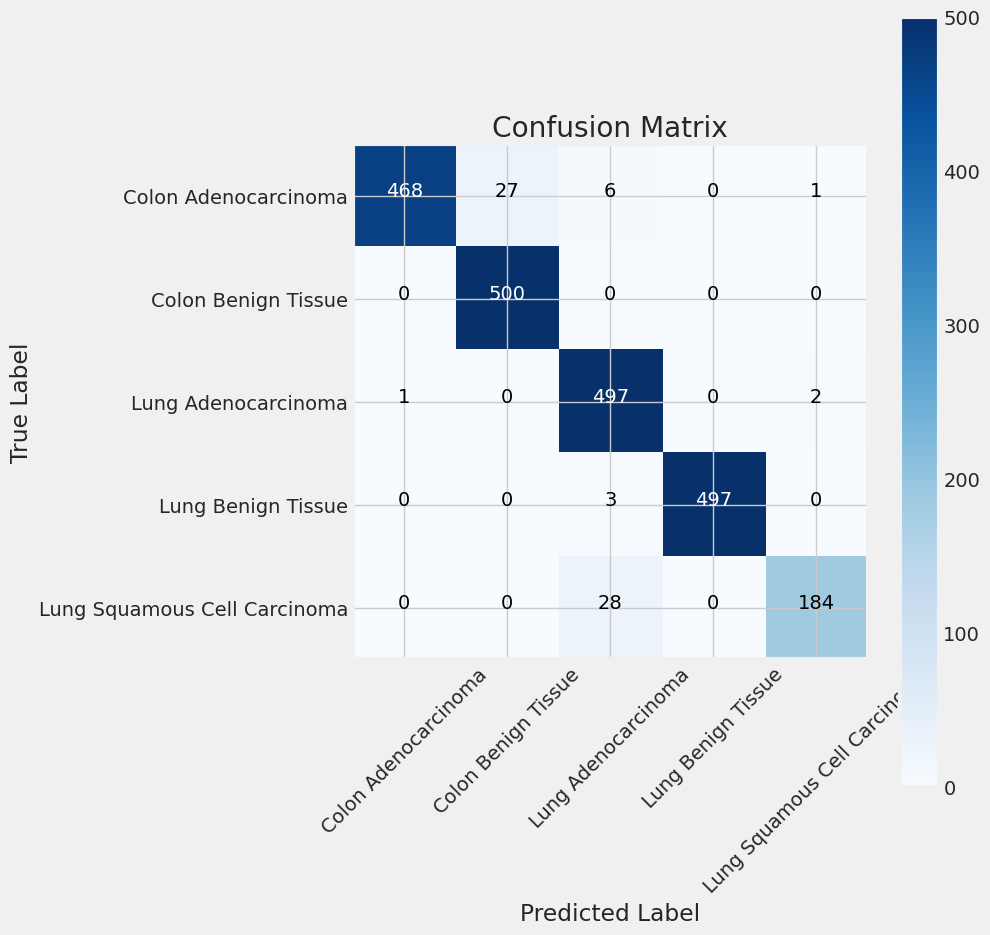

In [12]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [13]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       1.00      0.93      0.96       502
         Colon Benign Tissue       0.95      1.00      0.97       500
         Lung Adenocarcinoma       0.93      0.99      0.96       500
          Lung Benign Tissue       1.00      0.99      1.00       500
Lung Squamous Cell Carcinoma       0.98      0.87      0.92       212

                    accuracy                           0.97      2214
                   macro avg       0.97      0.96      0.96      2214
                weighted avg       0.97      0.97      0.97      2214



### Save model

In [22]:
# Define the path to save the model
model_path = "/content/sample_data/my_model.h5"

### Prediction using loaded_model

In [26]:
loaded_model = tf.keras.models.load_model('/content/my_model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [28]:
image_path = '/content/drive/MyDrive/Sample/colonca1.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 130ms/step
Colon Adenocarcinoma
